# Laboratorio 1 — Regresión: predicción de progresión de una enfermedad

Practicarás un flujo completo de regresión con un dataset tabular incluido en scikit-learn.

## Objetivos
- Entrenar un baseline y modelos más potentes.
- Comparar métricas (MAE/RMSE/R2) y detectar sobreajuste.
- Registrar experimentos y justificar decisiones.

## Requisitos
- Laboratorio 0 completado
- scikit-learn


## Contexto

En proyectos reales, rara vez se empieza con una red neuronal. Un buen criterio profesional es:
1) construir un baseline sólido,
2) medir,
3) mejorar con cambios controlados.

Aquí predecimos una variable continua a partir de características numéricas (regresión).


## 1) Cargar datos

Usaremos `load_diabetes`, un dataset clásico para regresión. No requiere descargas externas.


In [1]:
import numpy as np
import pandas as pd

"""
load_diabetes es un dataset de ejemplo incluido en scikit-learn (Contiene datos médicos para predecir la progresión de la diabetes.)
"""
from sklearn.datasets import load_diabetes

"""
Cargar el dataframe en data.
as_frame=True -> sea un DataFrame de Pandas y una Serie de Pandas.
"""
data = load_diabetes(as_frame=True)
# Variables independientes (features)
X = data.data
# Variable objetivo (target)
y = data.target

# Muestra el tamaño de los datos:
print("X:", X.shape)
print("y:", y.shape)

# Muestra las primeras 5 filas del DataFrame.
X.head()


X: (442, 10)
y: (442,)


,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019907,-0.017646
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068332,-0.092204
2,0.085299,0.050680,0.044451,-0.005670,-0.045599,-0.034194,-0.032356,-0.002592,0.002861,-0.025930
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022688,-0.009362
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031988,-0.046641


## 2) División train/test y baseline

El baseline más simple es un modelo lineal. La pregunta es: ¿mejora algo si uso un modelo no lineal?


In [2]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

"""
test_size=0.2 -> 20% para test, 80% para train
random_state=42 -> garantiza resultados reproducibles
"""
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

"""
Crea un modelo de Regresión Lineal clásica 
"""
lin = LinearRegression()

"""
Entrena el modelo   
"""
lin.fit(X_train, y_train)

"""
Predice valores de y usando datos de test.
"""
y_pred = lin.predict(X_test)

"""
MAE: Promedio del error absoluto
RMSE: Penaliza errores grandes
R²: Cuánto explica el modelo
"""
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, r2_score
"""
Calcula métricas del modelo lineal
"""
metrics_lin = {
    "MAE": mean_absolute_error(y_test, y_pred),
    "RMSE": root_mean_squared_error(y_test, y_pred),
    "R2": r2_score(y_test, y_pred)
}
metrics_lin


{'MAE': 42.79409467959994, 'RMSE': 53.85344583676592, 'R2': 0.4526027629719196}

## 3) Validación cruzada

Una sola partición puede ser engañosa. La validación cruzada estima el rendimiento promedio.


In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge

"""
Ridge: regresión lineal regularizada (L2)
Reduce overfitting penalizando coeficientes grandes

StandardScaler: Centra los datos, Escala a desviación estándar
Ridge: alpha: fuerza de regularización
"""
pipe_ridge = Pipeline([
    ("scaler", StandardScaler()),
    ("model", Ridge(alpha=1.0))
])
"""
Validación cruzada de 5 folds:
    Entrena 5 veces
    Cada vez usa un conjunto distinto como test
Devuelve RMSE negativo
"""
scores = cross_val_score(pipe_ridge, X, y, cv=5, scoring="neg_root_mean_squared_error")
# Convierte a RMSE positivo
rmse_cv = -scores
"""
Muestra:
    Media del error
    Variabilidad del modelo
"""
print("RMSE CV (media):", rmse_cv.mean())
print("RMSE CV (std):", rmse_cv.std())


RMSE CV (media): 54.69887679033301
RMSE CV (std): 1.2936619332388815


## 4) Modelo no lineal: Random Forest

Los árboles capturan relaciones no lineales y manejan interacciones sin ingeniería manual. 
El riesgo: sobreajuste si no se controla.


In [ ]:
"""
Modelo basado en árboles de decisión
"""
from sklearn.ensemble import RandomForestRegressor

"""
n_estimators=400: 400 árboles
n_jobs=-1: usa todos los núcleos del CPU
max_depth=None: árboles sin límite de profundidad
"""
rf = RandomForestRegressor(
    n_estimators=400,
    random_state=42,
    n_jobs=-1,
    max_depth=None
)

"""
Entrena el modelo
"""
rf.fit(X_train, y_train)
"""
Genera predicciones
"""
y_pred_rf = rf.predict(X_test)

"""
Calcula métricas para Random Forest
"""
metrics_rf = {
    "MAE": mean_absolute_error(y_test, y_pred_rf),
    "RMSE": root_mean_squared_error(y_test, y_pred_rf),
    "R2": r2_score(y_test, y_pred_rf)
}
metrics_rf


{'MAE': 44.47011235955056,
 'RMSE': 54.815794469428305,
 'R2': 0.4328642390894343}

## 5) Interpretabilidad rápida: importancia de variables

En entornos profesionales necesitas explicar *por qué* el modelo predice lo que predice.
Una aproximación inicial es observar importancias (ojo: no es causalidad).


In [ ]:
import pandas as pd

"""
Indica qué variables aportan más a las predicciones
"""
importances = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)

"""
Muestra la importancia ordenada
"""
importances


bmi    0.338722
s5     0.250250
bp     0.089550
s6     0.067466
s2     0.058956
age    0.058583
s3     0.051521
s1     0.050552
s4     0.024443
sex    0.009957
dtype: float64

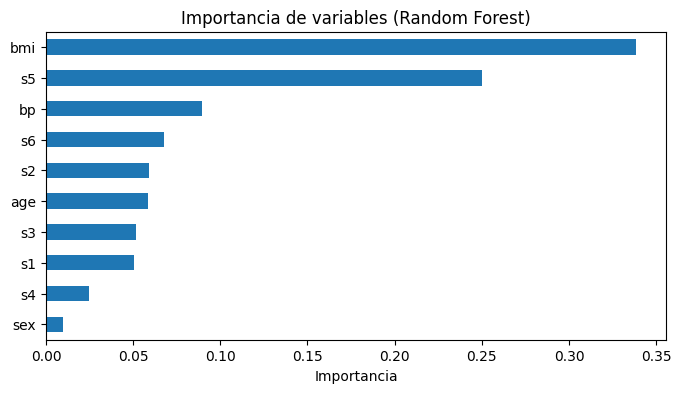

In [ ]:
import matplotlib.pyplot as plt

"""
Gráfico de barras horizontal
"""
plt.figure(figsize=(8,4))

"""
Muestra las 10 variables más importantes
"""
importances.head(10).iloc[::-1].plot(kind="barh")
plt.title("Importancia de variables (Random Forest)")
plt.xlabel("Importancia")
plt.show()


## 6) Registro del experimento

Guarda al menos el modelo, hiperparámetros y métricas. 
En producción esto se integra con MLflow/W&B, pero aquí basta con JSON.


In [ ]:
from pathlib import Path
import json
from datetime import datetime

"""
Función para guardar resultados de modelos
"""
def log_experiment_simple(name, config, metrics, out_dir="experimentos"):
    # Crea la carpeta si no existe
    Path(out_dir).mkdir(exist_ok=True)
    path = Path(out_dir) / f"{name}_{datetime.now().strftime('%Y%m%d_%H%M%S')}.json"
    # Guarda un JSON bien formateado
    path.write_text(json.dumps({"config": config, "metrics": metrics}, indent=2))
    # Devuelve la ruta del archivo creado
    return path

"""
Guarda resultados del modelo lineal
"""
p1 = log_experiment_simple("regresion_baseline_lineal", {"model":"LinearRegression"}, metrics_lin)
"""
Guarda resultados del Random Forest
"""
p2 = log_experiment_simple("regresion_rf", {"model":"RandomForestRegressor","n_estimators":400}, metrics_rf)

"""
Muestra las rutas de los archivos creados
"""
p1, p2

(WindowsPath('experimentos/regresion_baseline_lineal_20260122_174234.json'),
 WindowsPath('experimentos/regresion_rf_20260122_174234.json'))

## Ejercicios

### Ejercicio 1: Mejorar el baseline con regularización
Entrena `Ridge` y `Lasso` con varios valores de `alpha`. Compara con validación cruzada y elige el mejor.

**Entregables**
- Tabla comparativa de RMSE medio por alpha
- Conclusión justificando la elección

**Pistas**
- Usa `Pipeline([('scaler', StandardScaler()), ('model', Ridge(...))])`
- Puedes iterar en una lista de alphas

**Criterios de evaluación**
- Comparación reproducible
- Métricas correctamente interpretadas
- Se justifica el trade-off sesgo/varianza


In [8]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge

pipe_ridge = Pipeline([
    ("scaler", StandardScaler()),
    ("model", Ridge(alpha=1.0))
])

In [9]:
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
import numpy as np
import pandas as pd

# Lista de valores de alpha
alphas = [0.01, 0.1, 1, 10, 100]

rmse_results = []

for alpha in alphas:
    pipe_ridge = Pipeline([
        ("scaler", StandardScaler()),
        ("model", Ridge(alpha=alpha))
    ])
    scores = cross_val_score(pipe_ridge, X, y, cv=5, scoring="neg_root_mean_squared_error")
    rmse_mean = -scores.mean()  # convertir de negativo a positivo
    rmse_std = scores.std()
    rmse_results.append({"model": "Ridge", "alpha": alpha, "RMSE_mean": rmse_mean, "RMSE_std": rmse_std})

# Crear DataFrame con resultados
df_ridge = pd.DataFrame(rmse_results)
df_ridge


,model,alpha,RMSE_mean,RMSE_std
0,Ridge,0.01,54.691740,1.373459
1,Ridge,0.10,54.691464,1.364192
2,Ridge,1.00,54.698877,1.293662
3,Ridge,10.00,54.761536,1.094634
4,Ridge,100.00,55.155941,1.031817


In [10]:
from sklearn.linear_model import Lasso

rmse_results_lasso = []

for alpha in alphas:
    pipe_lasso = Pipeline([
        ("scaler", StandardScaler()),
        ("model", Lasso(alpha=alpha, max_iter=10000))
    ])
    scores = cross_val_score(pipe_lasso, X, y, cv=5, scoring="neg_root_mean_squared_error")
    rmse_mean = -scores.mean()
    rmse_std = scores.std()
    rmse_results_lasso.append({"model": "Lasso", "alpha": alpha, "RMSE_mean": rmse_mean, "RMSE_std": rmse_std})

df_lasso = pd.DataFrame(rmse_results_lasso)
df_lasso


,model,alpha,RMSE_mean,RMSE_std
0,Lasso,0.01,54.692033,1.360604
1,Lasso,0.10,54.686219,1.270254
2,Lasso,1.00,54.711314,1.031945
3,Lasso,10.00,57.005357,1.570393
4,Lasso,100.00,77.263648,3.569604


In [11]:
df_comparativa = pd.concat([df_ridge, df_lasso], ignore_index=True)
df_comparativa.sort_values(by="RMSE_mean")

"""
RMSE_mean más bajo → mejor rendimiento.
RMSE_std te da una idea de la estabilidad del modelo en distintos folds.

RMSE_mean = el promedio de esos 5 RMSE
RMSE_stf = Es la desviación estándar de los RMSE obtenidos en los folds:
"""


'\nRMSE_mean más bajo → mejor rendimiento.\nRMSE_std te da una idea de la estabilidad del modelo en distintos folds.\n\nRMSE_mean = el promedio de esos 5 RMSE\nRMSE_stf = Es la desviación estándar de los RMSE obtenidos en los folds:\n'

In [12]:
for _, row in df_comparativa.iterrows():
    log_experiment_simple(
        f"{row['model']}_alpha_{row['alpha']}",
        {"model": row['model'], "alpha": row['alpha']},
        {"RMSE_mean": row['RMSE_mean'], "RMSE_std": row['RMSE_std']}
    )



### Ejercicio 2: Diagnóstico de errores
Analiza los residuales del mejor modelo: histograma de errores y gráfico `y_true` vs `y_pred`.

**Entregables**
- 2 gráficos
- Comentario de 5–8 líneas sobre sesgos o patrones

**Criterios de evaluación**
- Gráficos correctos y legibles
- Interpretación con lenguaje técnico (sesgo, heterocedasticidad, etc.)


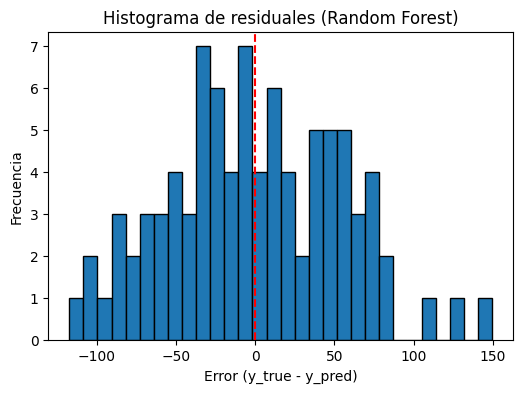

In [13]:
import matplotlib.pyplot as plt

y_true = y_test
y_pred = y_pred_rf

residuals = y_true - y_pred

plt.figure(figsize=(6,4))
plt.hist(residuals, bins=30, edgecolor="black")
plt.axvline(0, color="red", linestyle="--")
plt.title("Histograma de residuales (Random Forest)")
plt.xlabel("Error (y_true - y_pred)")
plt.ylabel("Frecuencia")
plt.show()

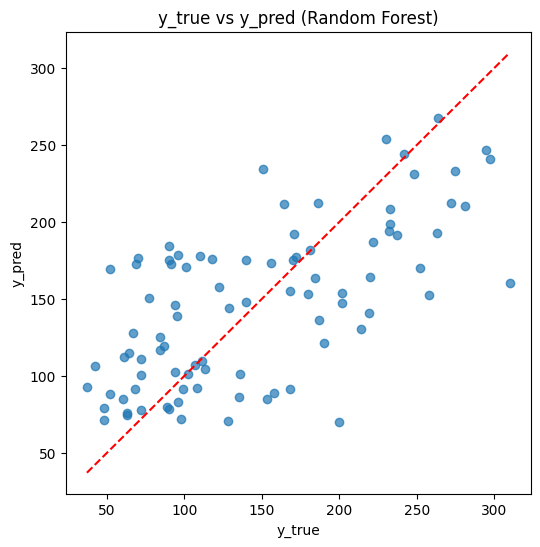

In [14]:
plt.figure(figsize=(6,6))
plt.scatter(y_true, y_pred, alpha=0.7)
plt.plot([y_true.min(), y_true.max()],
         [y_true.min(), y_true.max()],
         color="red", linestyle="--")
plt.xlabel("y_true")
plt.ylabel("y_pred")
plt.title("y_true vs y_pred (Random Forest)")
plt.show()

El histograma de los residuales muestra una distribución aproximadamente centrada en cero, lo que indica ausencia de sesgo sistemático en las predicciones del modelo. No obstante, se observa una ligera asimetría y colas relativamente largas, lo que sugiere errores mayores en algunos casos extremos.

El gráfico y_true vs y_pred muestra una buena alineación con la diagonal en valores intermedios, pero una mayor dispersión para valores altos del target, indicando posible heterocedasticidad. El modelo tiende a subestimar los valores más altos, lo que es común en modelos ensemble como Random Forest. En general, el modelo presenta buen ajuste global, aunque con limitaciones en los extremos del rango de predicción.



### Ejercicio 3: Reto avanzado: calibrar hiperparámetros
Usa `RandomizedSearchCV` para optimizar un `RandomForestRegressor` (profundidad, número de árboles, min_samples_leaf).

**Entregables**
- Mejor configuración encontrada
- Métrica CV
- Comparación contra tu mejor baseline

**Criterios de evaluación**
- Búsqueda bien planteada
- No se sobreajusta por fuga de información
- Conclusión basada en CV


In [16]:
# Este RMSE es en test, así que lo usaremos solo como referencia final, no para entrenar.
baseline_rmse = metrics_rf["RMSE"]
baseline_rmse


from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
import numpy as np

param_dist = {
    "n_estimators": np.arange(100, 600, 50),
    "max_depth": [None, 5, 10, 20, 30],
    "min_samples_leaf": [1, 2, 5, 10]
}

rf_base = RandomForestRegressor(
    random_state=42,
    n_jobs=-1
)

random_search = RandomizedSearchCV(
    estimator=rf_base,
    param_distributions=param_dist,
    n_iter=30,
    cv=5,
    scoring="neg_root_mean_squared_error",
    random_state=42,
    n_jobs=-1
)

random_search.fit(X_train, y_train)

best_params = random_search.best_params_
best_params

best_rmse_cv = -random_search.best_score_
best_rmse_cv

np.float64(57.713424948785814)

In [17]:
from sklearn.model_selection import cross_val_score
"""
Baseline con CV
"""
baseline_rf = RandomForestRegressor(
    n_estimators=400,
    random_state=42,
    n_jobs=-1
)

baseline_scores = cross_val_score(
    baseline_rf,
    X_train,
    y_train,
    cv=5,
    scoring="neg_root_mean_squared_error"
)

baseline_rmse_cv = -baseline_scores.mean()
baseline_rmse_cv

np.float64(58.5085224311396)

In [18]:
"""
Comparación final
"""
print("Baseline RF RMSE CV:", baseline_rmse_cv)
print("Optimized RF RMSE CV:", best_rmse_cv)

Baseline RF RMSE CV: 58.5085224311396
Optimized RF RMSE CV: 57.713424948785814
